In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import pickle
import torch
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import matplotlib.ticker as ticker

# os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
# os.environ["CUDA_VISIBLE_DEVICES"] = '5'
plt.style.use('seaborn-white')

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
results = {
    'Australian': {
        'GeoAdEx': [
            [[0.4579, 0.4457, 0.4437, 0.4372, 0.4428, 0.4487, 0.4531, 0.4534],
             [146, 187, 197, 204, 213, 222, 227, 233]],
            [[0.4510, 0.4308, 0.4182, 0.4125, 0.4164, 0.4204, 0.4264, 0.4271],
             [362, 592, 731, 760, 777, 802, 816, 829]],
            [[0.4476, 0.4210, 0.4032, 0.3976, 0.3959, 0.3984, 0.3997, 0.4018],
             [693, 1539, 2405, 2664, 2563, 2610, 2774, 2853]],
            [[0.4467, 0.4195, 0.3983, 0.3927, 0.3945, 0.3921, 0.4055, 0.4058],
             [762, 1988, 3684, 4318, 3778, 3877, 6175, 6334]],
        ],
        'S&W': [
            [[0.4910, 0.4616, 0.4484, 0.4456, 0.4451, 0.4361, 0.4356],
             [17, 97, 285, 600, 1145, 1791, 3893]]
        ],
        'Yang et al.': [
            [[0.4431, 0.4428, 0.4428, 0.4428, 0.4428, 0.4428, 0.4428, 0.4428],
             [10, 12, 15, 23, 36, 43, 42, 43]]
        ],
        'Wang et al.': [
            [[0.4560, 0.4527, 0.4527, 0.4527, 0.4527, 0.4527, 0.4527, 0.4527],
             [45, 98, 227, 542, 1294, 2197, 2325, 3292]]
        ],
    },
    'Covtype': {
        'GeoAdEx': [
            [[0.1559, 0.1470, 0.1433, 0.1441, 0.1441, 0.1439, 0.1440, 0.1444],
             [93, 97, 102, 110, 115, 120, 124, 129]],
            [[0.1518, 0.1419, 0.1415, 0.1412, 0.1421, 0.1403, 0.1409, 0.1422],
             [145, 157, 165, 196, 208, 228, 236, 242]],
            [[0.1481, 0.1418, 0.1387, 0.1385, 0.1372, 0.1367, 0.1367, 0.1367],
             [323, 358, 299, 389, 432, 524, 551, 620]],
            [[0.1472, 0.1390, 0.1387, 0.1385, 0.1369, 0.1365, 0.1365, 0.1365],
             [467, 541, 406, 512, 616, 777, 824, 864]],
        ],
        'S&W': [
            [[0.1843, 0.1694, 0.1614, 0.1616, 0.1626, 0.1600],
             [53, 364, 1185, 2639, 5145, 8100]]
        ],
        'Yang et al.': [
            [[0.2881, 0.2875, 0.2875, 0.2875], 
             [275, 629, 1231, 2463]]
        ],
        'Wang et al.': [
            [[0.1845, 0.1844, 0.1844, 0.1844, 0.1844, 0.1844],
             [83, 209, 836, 706, 1921, 4565]]
        ],
    },
    'Diabetes': {
        'GeoAdEx': [
            [[0.1030, 0.1017, 0.0982, 0.0987, 0.1009, 0.1015, 0.1018, 0.1023], 
             [169, 169, 162, 171, 178, 181, 188, 198]],
            [[0.1025, 0.0937, 0.0900, 0.0899, 0.0913, 0.0925, 0.0918, 0.0918],
             [486, 471, 472, 491, 525, 549, 567, 575]],
            [[0.0960, 0.0876, 0.0821, 0.0844, 0.0825, 0.0823, 0.0839, 0.0835],
             [1610, 1381, 1217, 1588, 1399, 1521, 1629, 1654]],
            [[0.0939, 0.0845, 0.0790, 0.0802, 0.0786, 0.0784, 0.0797, 0.0802],
             [2624, 2184, 1965, 2474, 2127, 2322, 2424, 2524]],
        ],
        'S&W': [
            [[0.1080, 0.0982, 0.0926, 0.0920, 0.0929, 0.0980, 0.0980],
             [17, 95, 278, 593, 1248, 2042, 3686]]
        ],
        'Yang et al.': [
            [[0.1518, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516, 0.1516],
             [10, 12, 42, 24, 34, 43, 44, 44]]
        ],
        'Wang et al.': [
            [[0.1161, 0.1154, 0.1153, 0.1153, 0.1153, 0.1153, 0.1153, 0.1153],
            [14, 32, 74, 178, 370, 734, 997, 1807]]
        ],
    },
}

In [45]:

def plot(dataset):
    lw = 4
    ms = 12
    labelsize = 24
    ticksize = 24
    legendsize = 14
    markers = ['-o', '-^', '-d', '-X']
    sublab = ['tl=2', 'tl=10', 'tl=50', 'tl=100']
    # submarkers = ['--o', '--s', '--*', '--p']
    submarkers = ['-o', '-s', '-v', '-p']

    plt.figure(figsize=(7, 6))

    data = results[dataset]
    for i, label in enumerate(data):
        if label == 'GeoAdEx':
            for j, sl in enumerate(sublab):
                plt.plot(data[label][j][1], data[label][j][0],
                        submarkers[j], lw=lw, ms=ms, alpha=1, label=f'{label} ({sl})',
                        markeredgewidth=1, markeredgecolor='w')
        else:
            plt.plot(data[label][0][1], data[label][0][0],
                    markers[i], lw=lw, ms=ms, label=label,
                    markeredgewidth=1, markeredgecolor='w')

    plt.legend(prop={'size': legendsize}, frameon=True,
            #    bbox_to_anchor=(0.09, 0.4)
               )
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.xlabel(r'Total Runtime (s)', fontsize=labelsize)
    plt.ylabel(r'Mean Adversarial Distance', fontsize=labelsize)
    plt.xscale('log')
    # plt.ylim(0, 100)
    plt.grid(linestyle='dotted', lw=2)
    plt.tight_layout()
    plt.title(dataset, fontsize=labelsize)
    plt.savefig(f'{dataset}.png', dpi=400, bbox_inches='tight')
    plt.show()

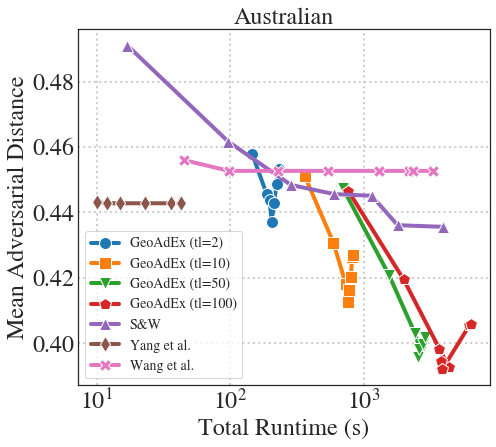

In [15]:
plot('Australian')

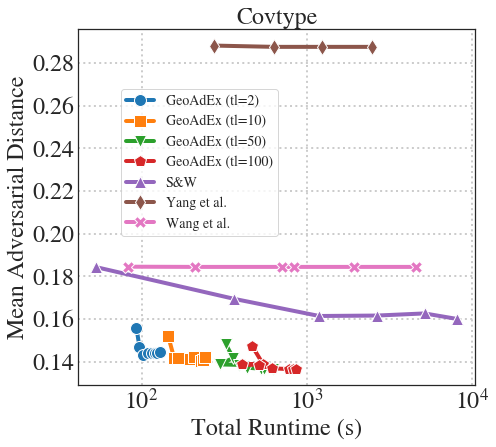

In [44]:
plot('Covtype')

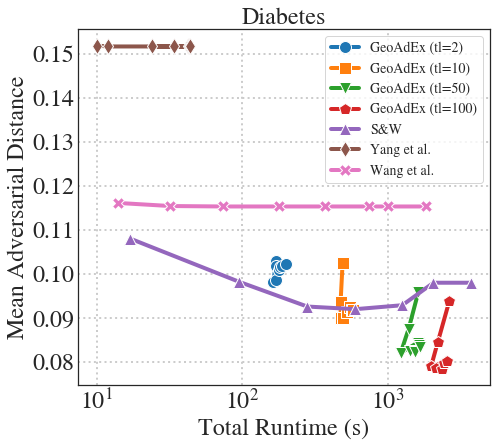

In [46]:
plot('Diabetes')

In [35]:
dist = [[0.0843,0.0790,0.0781,0.0760,0.0742,0.0737,0.0730,0.0721],
        [0.0798,0.0767,0.0757,0.0744,0.0735,0.0725,0.0721,0.0721],
        [0.0790,0.0760,0.0751,0.0739,0.0730,0.0721,0.0720,0.0720],
        [0.0772,0.0757,0.0745,0.0737,0.0729,0.0722,0.0719,0.0719]]

time = [[229,377,594,930,1419,1755,2010,2246],
        [334,473,687,1009,1470,1775,2059,2237],
        [582,721,935,1253,1710,2141,2310,2523],
        [1015,1152,1362,1684,2128,2442,2710,2913]]

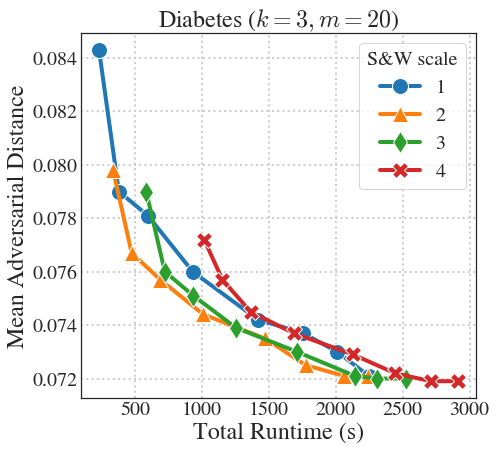

In [40]:
lw = 4
ms = 16
labelsize = 24
ticksize = 20
legendsize = 20
markers = ['-o', '-^', '-d', '-X']

plt.figure(figsize=(7, 6))

for i in range(4):
    plt.plot(time[i], dist[i],
             markers[i], lw=lw, ms=ms, label=i + 1,
             markeredgewidth=1, markeredgecolor='w')

plt.legend(prop={'size': legendsize}, frameon=True,
           title='S&W scale', title_fontsize=legendsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlabel(r'Total Runtime (s)', fontsize=labelsize)
plt.ylabel(r'Mean Adversarial Distance', fontsize=labelsize)
# plt.xscale('log')
# plt.ylim(0, 100)
plt.grid(linestyle='dotted', lw=2)
plt.tight_layout()
plt.title(r'Diabetes ($k=3, m=20$)', fontsize=labelsize)
plt.savefig(f'sw_scale.png', dpi=400, bbox_inches='tight')
plt.show()

In [33]:
time = np.array([
                [4318.47,5381.28],
                [561.38,1163.72],
                [2474.18,2827.50],
                [1763.95,7057.41],
                [2073.80,2740.98],
                [2799.44,4122.56],
                [6223.93,6384.92]
                ])
labels = ['', 'Australian', 'Covtype', 'Diabetes', 'Fourclass', 'Gaussian', 'Letters', 'fmnist06']
percent = (time[:, 1] - time[:, 0]) / time[:, 0] * 100
percent = [f'+{int(p):d}%' for p in percent]

<ipython-input-34-72dcd855079b>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha="right")


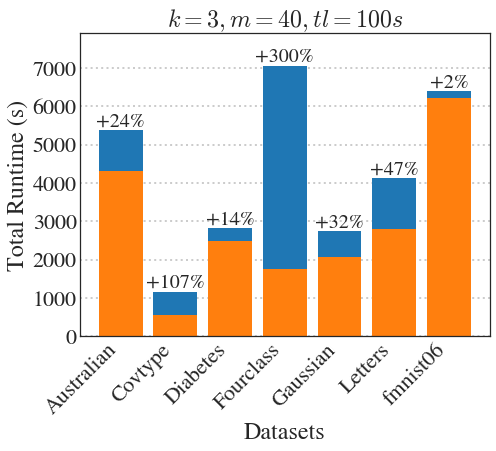

In [34]:
lw = 4
ms = 16
labelsize = 24
ticksize = 22
legendsize = 20

plt.figure(figsize=(7, 6))
x = np.arange(len(time))
plt.bar(x, time[:, 1])
plt.bar(x, time[:, 0])
ax = plt.gca()
ax.bar_label(ax.containers[0], percent, fontsize=legendsize)
ax.set_xticklabels(labels, rotation=45, ha="right")
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlabel(r'Datasets', fontsize=labelsize)
plt.ylabel(r'Total Runtime (s)', fontsize=labelsize)
# plt.xscale('log')
plt.ylim(0, 7900)
plt.grid(linestyle='dotted', lw=2, axis='y')
plt.tight_layout()
plt.title(r'$k=3, m=40, tl=100s$', fontsize=labelsize)
plt.savefig('init.png', dpi=400, bbox_inches='tight')
plt.show()